In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from LSTM import Model

import numpy as np
import torch.optim as optim
import torch.utils.data as data

In [2]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X,dtype=torch.float32), torch.tensor(y,dtype=torch.float32)

In [3]:
raw_data = pd.read_csv("./data/data.csv")

In [4]:
df = raw_data[raw_data['unique_id']=='AAAHol']

In [5]:
# train-test split for time series
timeseries = df[['visits']].values.astype('float32')
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

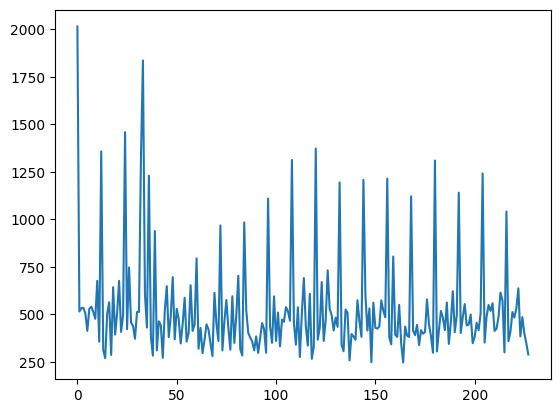

In [6]:
plt.plot(timeseries)
plt.show()

In [11]:
lookback = 32
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([120, 32, 1]) torch.Size([120, 32, 1])
torch.Size([44, 32, 1]) torch.Size([44, 32, 1])


In [12]:
model = Model(input_size=32,hidden_size=256)
optimizer = optim.Adam(model.parameters(),lr=1e-6)
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train,y_train),shuffle=True,batch_size=8)

In [13]:
n_epochs = 2000
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


Epoch 0: train RMSE 583.1934, test RMSE 552.7145
Epoch 100: train RMSE 257.2057, test RMSE 217.1905
Epoch 200: train RMSE 210.4950, test RMSE 234.0870
Epoch 300: train RMSE 144.7804, test RMSE 275.4001
Epoch 400: train RMSE 124.5683, test RMSE 286.1448
Epoch 500: train RMSE 121.9121, test RMSE 282.8590
Epoch 600: train RMSE 112.5615, test RMSE 287.3409
Epoch 700: train RMSE 122.9857, test RMSE 302.1924
Epoch 800: train RMSE 121.2792, test RMSE 293.2830
Epoch 900: train RMSE 104.5825, test RMSE 284.4225
Epoch 1000: train RMSE 117.9489, test RMSE 276.5175
Epoch 1100: train RMSE 104.2455, test RMSE 282.6115
Epoch 1200: train RMSE 111.9988, test RMSE 263.7829
Epoch 1300: train RMSE 93.7597, test RMSE 301.5989
Epoch 1400: train RMSE 104.3969, test RMSE 277.7678
Epoch 1500: train RMSE 94.2025, test RMSE 288.4630
Epoch 1600: train RMSE 96.0717, test RMSE 284.9266
Epoch 1700: train RMSE 100.4070, test RMSE 275.1929
Epoch 1800: train RMSE 93.0871, test RMSE 292.2609
Epoch 1900: train RMSE 88.92

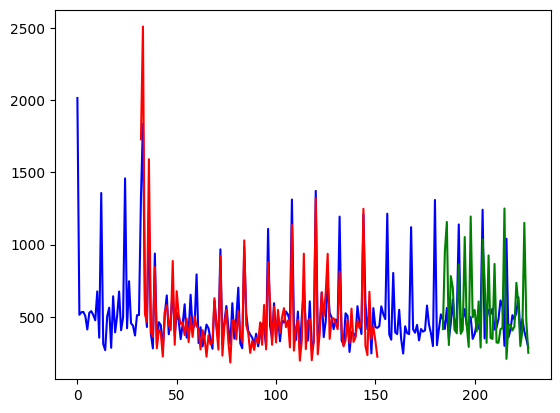

In [14]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()